Demo notebook for using a 2D CNN/Unet for segmentation and/or image generation 

currently meant to be using the "splat" branch of quantem
- parts of this require skimage and sklearn, but both are useful packages so it's no harm to add them


Arthur McCray  
Last remembered to update this line: 7/7/25

# TODO 
- HDBSCAN clustering 
- quantem config file

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import torch
from quantem.core import config
from quantem.core.ml.cnn2d import CNN2d
from quantem.core.visualization import show_2d
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from tqdm.auto import tqdm

config.set({"device": "cuda:0"})
print(config.get("device"))


Available GPUs: 4
Using GPU ID 1 : NVIDIA L40S


# Initialization

In [3]:
input_channels = 1  # 1 for a greyscale image, 3 for RGB, 4 for RGBA, etc.
image_shape = (256, 256)  # shape of the image input (same as output) (height, width)
shape = (input_channels, *image_shape)
start_filters = 16
num_layers = 3
num_per_layer = 2
use_skip_connections = True
dtype = torch.float32
dropout = 0

model = CNN2d(
    in_channels=input_channels,
    start_filters=start_filters,
    num_layers=num_layers,
    num_per_layer=num_per_layer,
    use_skip_connections=use_skip_connections,
    dtype=dtype,
    dropout=dropout,
)

batch_size = 5
input_shape = (batch_size, *shape)
t_inp = torch.rand(*input_shape, dtype=dtype)

t_out = model.forward(t_inp)
print(f"in/out shapes (batch size = {batch_size}): {t_inp.shape} -> {t_out.shape}")
print(t_inp.dtype, t_out.dtype)

in/out shapes (batch size = 5): torch.Size([5, 1, 256, 256]) -> torch.Size([5, 1, 256, 256])
torch.float32 torch.float32


In [4]:
summary(model, shape, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
              ReLU-3         [-1, 16, 256, 256]               0
              ReLU-4         [-1, 16, 256, 256]               0
              ReLU-5         [-1, 16, 256, 256]               0
              ReLU-6         [-1, 16, 256, 256]               0
              ReLU-7         [-1, 16, 256, 256]               0
              ReLU-8         [-1, 16, 256, 256]               0
              ReLU-9         [-1, 16, 256, 256]               0
      BatchNorm2d-10         [-1, 16, 256, 256]              32
           Conv2d-11         [-1, 16, 256, 256]           2,320
             ReLU-12         [-1, 16, 256, 256]               0
             ReLU-13         [-1, 16, 256, 256]               0
             ReLU-14         [-1, 16, 2

# Segmentation

In [5]:
### helpers

from scipy.ndimage import distance_transform_edt
from skimage.draw import random_shapes
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.cluster import DBSCAN, MeanShift


class SimpleDataset(Dataset):
    def __init__(self, dps, labels):
        self.dps = [torch.tensor(dp, dtype=torch.float32) for dp in dps]
        self.labels = [torch.tensor(lbl, dtype=torch.float32) for lbl in labels]

    def __len__(self):
        return len(self.dps)

    def __getitem__(self, idx):
        return self.dps[idx], self.labels[idx]


def make_data(
    image_shape=(128, 128),
    n_images=10,
    max_shapes=6,
    min_shapes=2,
    allow_overlap=False,
    rng=None,
    instance=False,
):
    """
    Generate semantic segmentation dataset with random shapes.
    """
    images = []
    labels = []

    for _ in tqdm(range(n_images)):
        img, lbl = random_shapes(
            image_shape,
            max_shapes=max_shapes,
            min_shapes=min_shapes,
            num_channels=1,
            min_size=10,
            allow_overlap=allow_overlap,
            rng=rng,
            intensity_range=(0, 200),
        )
        img = img.squeeze()
        # Semantic label: background is 0, shapes are nonzero
        if instance:
            label = np.zeros_like(img)
            for i, val in enumerate(np.unique(img)):
                if val == 255:
                    continue
                label[img == val] = min(i+5, 255) # making it a little easier
        else:
            label = np.array(img != 255).astype(np.uint8)
        img -= img.min()
        img = img / img.max()  # Normalize to [0, 1]

        images.append(img[None, ...])  # Add channel dimension
        labels.append(label[None,])

    images = np.stack(images, axis=0)  # (N, 1, H, W,
    labels = np.stack(labels, axis=0)  # (N, H, W)
    return images, labels

    # augment the dataset with random rotations and flips


def augment_dataset(
    images, labels, augment_factor=2, noise_level=0.0, rng=None, flip=True, rotate=True
):
    """
    Augment dataset with random rotations and flips.
    """
    augmented_images = []
    augmented_labels = []
    if rng is None:
        rng = np.random.default_rng()

    for img, lbl in tqdm(zip(images, labels), total=len(images)):
        for _ in range(augment_factor):
            img_aug = img.copy()
            lbl_aug = lbl.copy()
            if rotate:
                n_rot = int(rng.integers(0, 4))
                img_aug = np.rot90(img, k=n_rot, axes=(-2, -1))
                lbl_aug = np.rot90(lbl, k=n_rot, axes=(-2, -1))
            if flip:
                if rng.random() > 0.5:  # Random horizontal flip
                    img_aug = np.flip(img_aug, axis=-1)
                    lbl_aug = np.flip(lbl_aug, axis=-1)

                if rng.random() > 0.5:  # Random vertical flip
                    img_aug = np.flip(img_aug, axis=-2)
                    lbl_aug = np.flip(lbl_aug, axis=-2)

            if noise_level > 0:
                img_aug = noise_image(img_aug, noise_level=noise_level, rng=rng)

            augmented_images.append(img_aug)
            augmented_labels.append(lbl_aug)

    augmented_images = np.stack(augmented_images, axis=0)  # (N, C, H, W)
    augmented_labels = np.stack(augmented_labels, axis=0)  # (N, H, W)

    return augmented_images, augmented_labels


def noise_image(image, noise_level=0.1, rng=None):
    """
    Add Gaussian noise to an image.
    """
    if rng is None:
        rng = np.random.default_rng()

    noise = rng.normal(0, noise_level, image.shape).astype(image.dtype)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure values are in [0, 1]

    return noisy_image


def dbscan_clustering(nn_output, semantic_threshold=0.5, eps=1.0, min_samples=10):
    semantic, offset_row, offset_col = nn_output[0], nn_output[2], nn_output[3]
    H, W = semantic.shape

    fg_mask = semantic > semantic_threshold
    fg_coords = np.where(fg_mask)

    if len(fg_coords[0]) == 0:
        return np.zeros((H, W), dtype=np.int32)

    pixel_positions = np.column_stack([fg_coords[1], fg_coords[0]])
    offset_vectors = np.column_stack([offset_col[fg_coords], offset_row[fg_coords]])
    target_positions = pixel_positions + offset_vectors

    cluster_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(target_positions)

    instance_map = np.zeros((H, W), dtype=np.int32)
    valid_pixels = cluster_labels >= 0
    if np.any(valid_pixels):
        instance_map[fg_coords[0][valid_pixels], fg_coords[1][valid_pixels]] = (
            cluster_labels[valid_pixels] + 1
        )

    return instance_map


def meanshift_clustering(nn_output, semantic_threshold=0.5, bandwidth=10.0):
    semantic, offset_row, offset_col = nn_output[0], nn_output[2], nn_output[3]
    H, W = semantic.shape

    fg_mask = semantic > semantic_threshold
    fg_coords = np.where(fg_mask)

    if len(fg_coords[0]) == 0:
        return np.zeros((H, W), dtype=np.int32)

    pixel_positions = np.column_stack([fg_coords[1], fg_coords[0]])
    offset_vectors = np.column_stack([offset_col[fg_coords], offset_row[fg_coords]])
    target_positions = pixel_positions + offset_vectors

    cluster_labels = MeanShift(bandwidth=bandwidth).fit_predict(target_positions)

    instance_map = np.zeros((H, W), dtype=np.int32)
    instance_map[fg_coords[0], fg_coords[1]] = cluster_labels + 1

    return instance_map


def watershed_clustering(
    nn_output, semantic_threshold=0.5, center_threshold=0.3, use_distance_map=False, min_distance=5
):
    semantic, centers, offset_row, offset_col = (
        nn_output[0],
        nn_output[1],
        nn_output[2],
        nn_output[3],
    )
    H, W = semantic.shape

    fg_mask = semantic > semantic_threshold
    if not np.any(fg_mask):
        return np.zeros((H, W), dtype=np.int32)

    center_peaks = peak_local_max(
        centers, min_distance=min_distance, threshold_abs=center_threshold
    )

    if len(center_peaks[0]) == 0:
        return ndi.label(fg_mask)[0]

    seeds = np.zeros((H, W), dtype=np.int32)
    for i, (row, col) in enumerate(center_peaks):
        seeds[row, col] = i + 1

    if use_distance_map:
        surface = -1 * distance_transform_edt(fg_mask)
    else:
        offset_magnitude = np.sqrt(offset_row**2 + offset_col**2)
        surface = offset_magnitude
        surface[~fg_mask] = surface.max()

    return watershed(surface, seeds, mask=fg_mask)


## semantic segmentation

### make a training set 

  0%|          | 0/500 [00:00<?, ?it/s]

images shape: (500, 1, 128, 128)
labels shape: (500, 1, 128, 128)


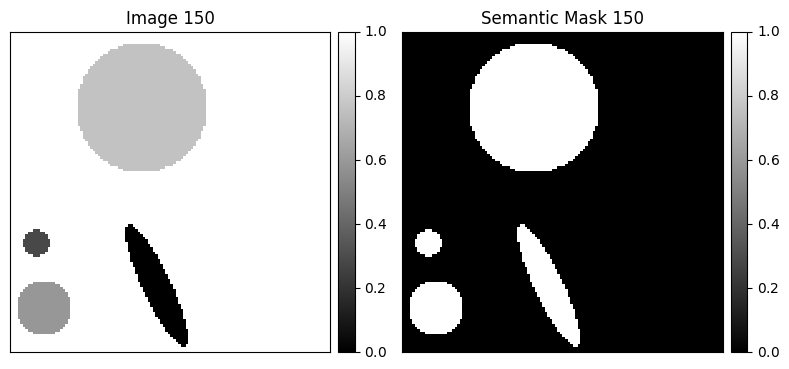

In [6]:
image_shape = (128, 128)
n_images = 500
rng_seed = 42


rng = np.random.default_rng(rng_seed)
rng_torch = torch.Generator().manual_seed(rng_seed)

images, labels = make_data(
    image_shape=image_shape, n_images=n_images, allow_overlap=False, rng=rng, instance=False
)

print("images shape:", images.shape)
print("labels shape:", labels.shape)

i = 150
show_2d(
    [
        images[i].squeeze(),
        labels[i].squeeze(),
    ],
    cbar=True,
    norm="minmax",
    title=[f"Image {i}", f"Semantic Mask {i}"],
);

### Augment and add noise to the data. This can/should be done in the dataloader, but including here to be more explicit/clear
- this is done to expand our training set in cases where we have limited training data

  0%|          | 0/500 [00:00<?, ?it/s]

Final augmented dataset shape: (500, 1, 128, 128), labels shape: (500, 1, 128, 128)


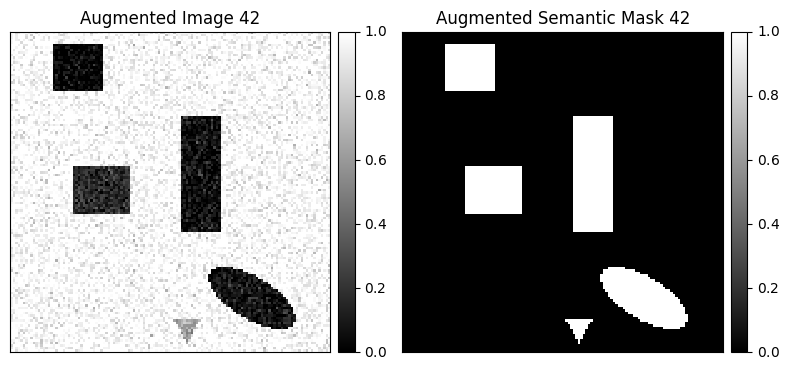

In [7]:
augment_factor = 1  ## not augmenting by flipping/rotating, just adding noise
## If using each image multiple times, need to make sure that the same image doesn't appear in
## both the training and validation sets

augmented_images, augmented_labels = augment_dataset(
    images, labels, augment_factor=augment_factor, noise_level=0.1, rng=rng
)

print(
    f"Final augmented dataset shape: {augmented_images.shape}, labels shape: {augmented_labels.shape}"
)

i = 42
show_2d(
    [
        augmented_images[i].squeeze(),
        augmented_labels[i].squeeze(),
    ],
    cbar=True,
    norm="minmax",
    title=[f"Augmented Image {i}", f"Augmented Semantic Mask {i}"],
);

### prepare the dataset with torch
- split into train/val sets and batches

In [8]:
dataset = SimpleDataset(augmented_images, augmented_labels)

# Split into train and validation sets
val_factor = 0.2
train_size = int((1 - val_factor) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=rng_torch)

print(f"Length of train dataset: {len(train_dataset)} | validation dataset: {len(val_dataset)}")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Train loader batches: {len(train_loader)} | Validation loader batches: {len(val_loader)}")

Length of train dataset: 400 | validation dataset: 100
Train loader batches: 13 | Validation loader batches: 4


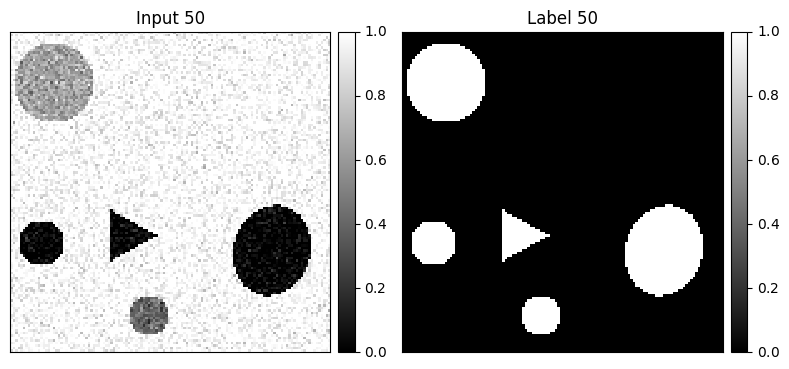

In [9]:
i = 50
input, label = dataset[i]
show_2d(
    [
        input.squeeze(),
        label.squeeze(),
    ],
    cbar=True,
    norm="minmax",
    title=[f"Input {i}", f"Label {i}"],
);

### Set up the NN, optimizer, and train

In [10]:
model = CNN2d(
    in_channels=1,
    final_activation=torch.nn.Sigmoid(),  # Use Sigmoid for binary classification
)
model = model.to(gpu_id)

optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-5 * np.sqrt(batch_size)
)  # Adjust learning rate based on batch size
criterion = torch.nn.BCELoss()  # cross-entropy loss for binary classification

train_losses = []
val_losses = []

  0%|          | 0/100 [00:00<?, ?it/s]

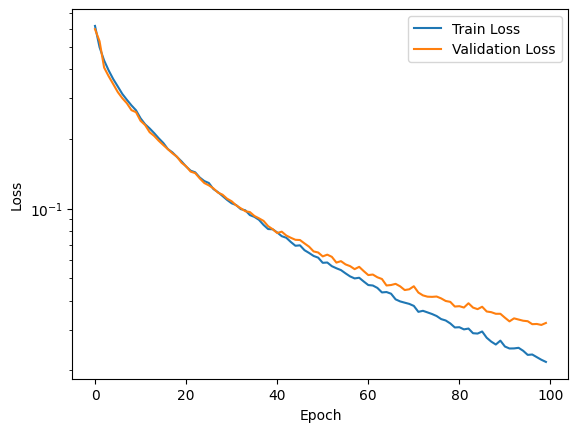

In [11]:
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(gpu_id), targets.to(gpu_id)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(gpu_id), targets.to(gpu_id)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

fig, ax = plt.subplots()
ax.semilogy(train_losses, label="Train Loss")
ax.semilogy(val_losses, label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()


note the separation training and validation loss. This indicates overtraining (though the val loss is still going down, which is good) and tells us we need more training data

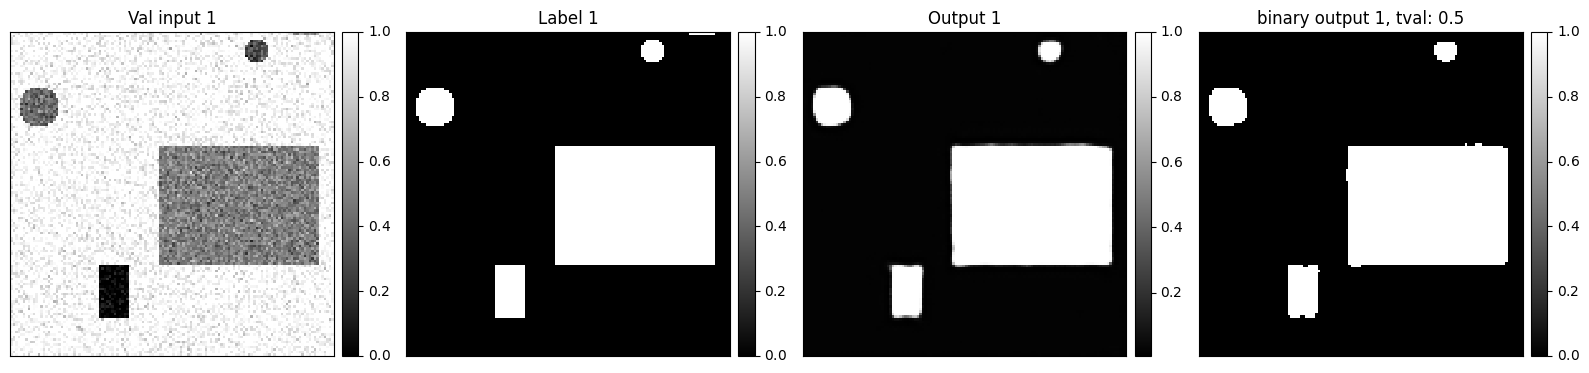

In [12]:
i = 1
thresh_val = 0.5

inp, lab = val_dataset[i]
out = model(inp[None, ...].to(gpu_id)).squeeze().cpu().detach().numpy()
thresh = (out > thresh_val).astype(np.float32)
show_2d(
    [
        inp.squeeze(),
        lab.squeeze(),
        out.squeeze(),
        thresh.squeeze(),
    ],
    cbar=True,
    norm="minmax",
    title=[f"Val input {i}", f"Label {i}", f"Output {i}", f"binary output {i}, tval: {thresh_val}"],
);


## instance segmentation with multi-head output
now allowing shapes to be overlapping

  0%|          | 0/20000 [00:00<?, ?it/s]

images shape: (20000, 1, 64, 64)
instance_masks shape: (20000, 64, 64)


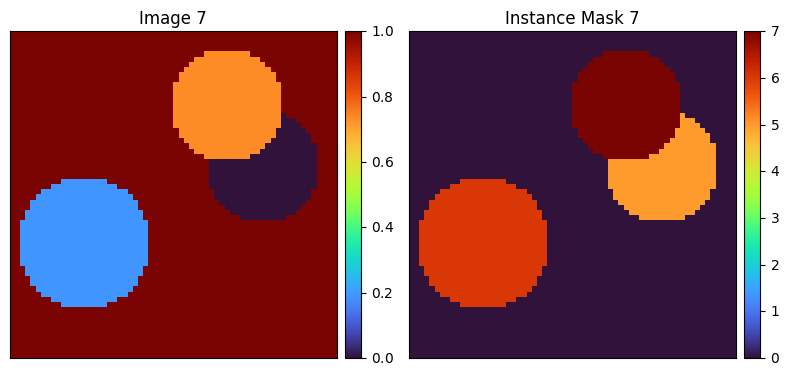

In [13]:
image_shape = (64, 64)
n_images = 20_000 # waaay more data is required than semantic segmentation
rng_seed = 42

rng = np.random.default_rng(rng_seed)
rng_torch = torch.Generator().manual_seed(rng_seed)

images, instance_masks = make_data(
    min_shapes=2,
    max_shapes=6,
    image_shape=image_shape,
    n_images=n_images,
    allow_overlap=True,
    rng=rng,
    instance=True,
)
instance_masks = instance_masks.squeeze()

print("images shape:", images.shape)
print("instance_masks shape:", instance_masks.shape)

i = 7
show_2d(
    [
        images[i].squeeze(),
        instance_masks[i],
    ],
    cbar=True,
    norm="minmax",
    title=[f"Image {i}", f"Instance Mask {i}"],
    cmap='turbo'
);

We have the instance segmented "truth" now, but what the model outputs (and what it will be trained against, therefore) are targets that can be used to reconstruct this segmented image using more conventional non-ml algorithms. So we need a way of generating those training targets from this instance segmented truth: 

In [14]:
def generate_training_targets(instance_labels, sigma_center=1):
    """
    Generate training targets from instance labels

    Args:
        instance_labels: (H, W) numpy array where 0=background, 1=obj1, 2=obj2, etc.
        sigma_center: Standard deviation for Gaussian center heatmaps

    Returns:
        np array of shape (4, H, W) with first axis channels corresponding to:
        - semantic: (H, W) binary mask
        - centers: (H, W) center heatmap
        - offset y (row)
        - offset x (column)
    """
    H, W = instance_labels.shape

    semantic_mask = (instance_labels > 0).astype(np.float32)

    offset_field = np.zeros((2, H, W), dtype=np.float32)
    center_heatmap = np.zeros((H, W), dtype=np.float32)
    instance_ids = np.unique(instance_labels)[1:]

    if len(instance_ids) == 0:
        # No instances found, return empty targets
        return np.stack([semantic_mask, center_heatmap, offset_field[0], offset_field[1]])

    y_grid, x_grid = np.mgrid[0:H, 0:W]
    for instance_id in instance_ids:
        instance_mask = instance_labels == instance_id
        center_y, center_x = ndi.center_of_mass(instance_mask)
        dy = center_y - y_grid
        dx = center_x - x_grid

        offset_field[0][instance_mask] = dy[instance_mask]
        offset_field[1][instance_mask] = dx[instance_mask]

        dist_sq = (x_grid - center_x) ** 2 + (y_grid - center_y) ** 2
        gaussian = np.exp(-dist_sq / (2 * sigma_center**2))

        # handle overlapping Gaussians
        center_heatmap = np.maximum(center_heatmap, gaussian)
    return np.stack([semantic_mask, center_heatmap, offset_field[0], offset_field[1]])

Specifically we will have the model output: 
- A semantic segmented mask
- The center locations of each object
- The offsets (y and x shifts) that point towards the center for each pixel 

(4, 64, 64)


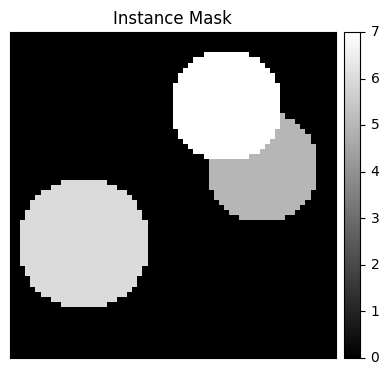

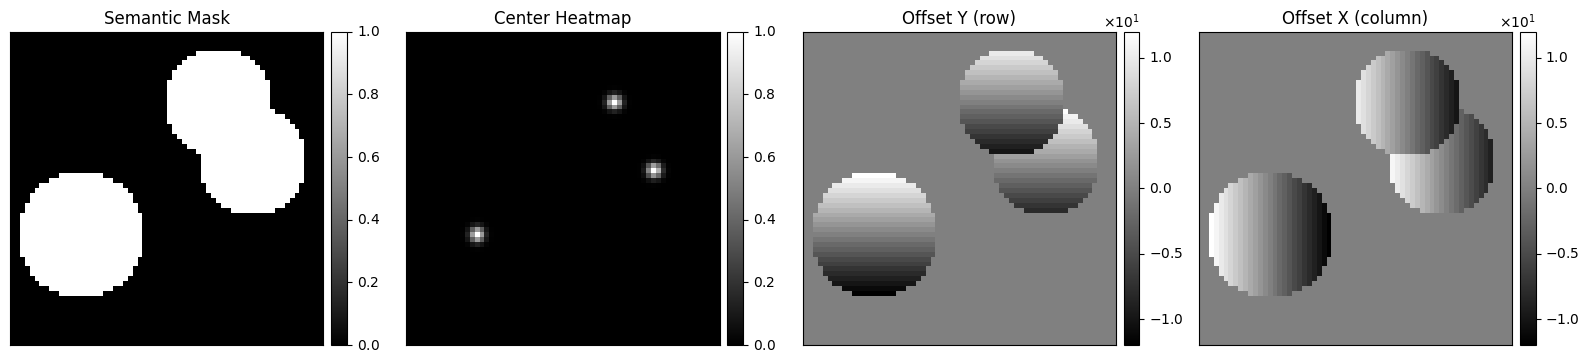

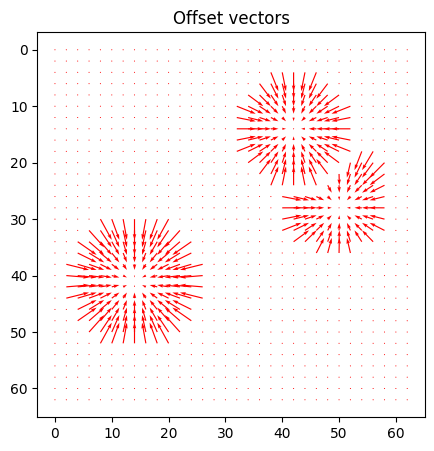

In [15]:
# Generate targets
i = 7
targets = generate_training_targets(instance_masks[i])

print(targets.shape)

show_2d(instance_masks[i], cbar=True, norm="minmax", title="Instance Mask")

show_2d(
    [
        targets[0],
        targets[1],
        targets[2],
        targets[3],
    ],
    cbar=True,
    norm="minmax",
    title=[
        "Semantic Mask",
        "Center Heatmap",
        "Offset Y (row)",
        "Offset X (column)",
    ],
)

fig, ax = plt.subplots(figsize=(5, 5))
img = inp.squeeze().cpu().numpy() if hasattr(inp, "cpu") else inp.squeeze()
offset_y = targets[2]
offset_x = targets[3]
step = 2  # subsample for clarity
Y, X = np.mgrid[0:offset_y.shape[0], 0:offset_y.shape[1]]
ax.quiver(
    X[::step, ::step],
    Y[::step, ::step],
    offset_x[::step, ::step],
    offset_y[::step, ::step],
    color="red",
    angles="xy",
    scale_units="xy",
    scale=3,
    width=0.003,
)
ax.invert_yaxis()
ax.set_title("Offset vectors")
plt.show()

we can use clustering methods to reconstruct these labels (or really the NN output) into instance segmentation masks. Note that some methods (like watershed) don't work very well with heavily overlapping objects, unless you also have the NN produce outlines of the objects (which is brittle and limiting). We therefore have the NN output the shifts, which can be used with methods like DBSCAN, which are much generally more accurate. That said, we also have the model output the centers which can be used with the offsets for watershed segmentation. There are a few parameters that need to be tuned for DBSCAN, while watershed doesn't really have any. 

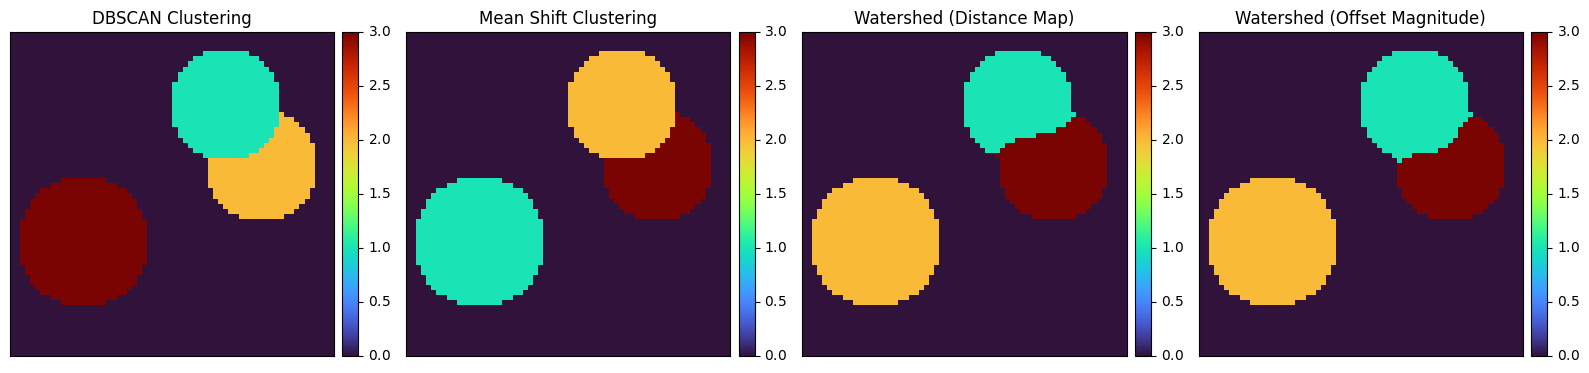

In [16]:
show_2d(
    [
        dbscan_clustering(targets),
        meanshift_clustering(targets),
        watershed_clustering(targets, use_distance_map=True),
        watershed_clustering(targets, use_distance_map=False),
    ],
    cbar=True,
    norm="minmax",
    title=[
        "DBSCAN Clustering",
        "Mean Shift Clustering",
        "Watershed (Distance Map)",
        "Watershed (Offset Magnitude)",
    ],
    cmap="turbo",
);

In [17]:
# so now updating our training labels
labels = []
for m in tqdm(instance_masks):
    labels.append(generate_training_targets(m))

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Final augmented dataset shape: (20000, 1, 64, 64), labels shape: (20000, 4, 64, 64)


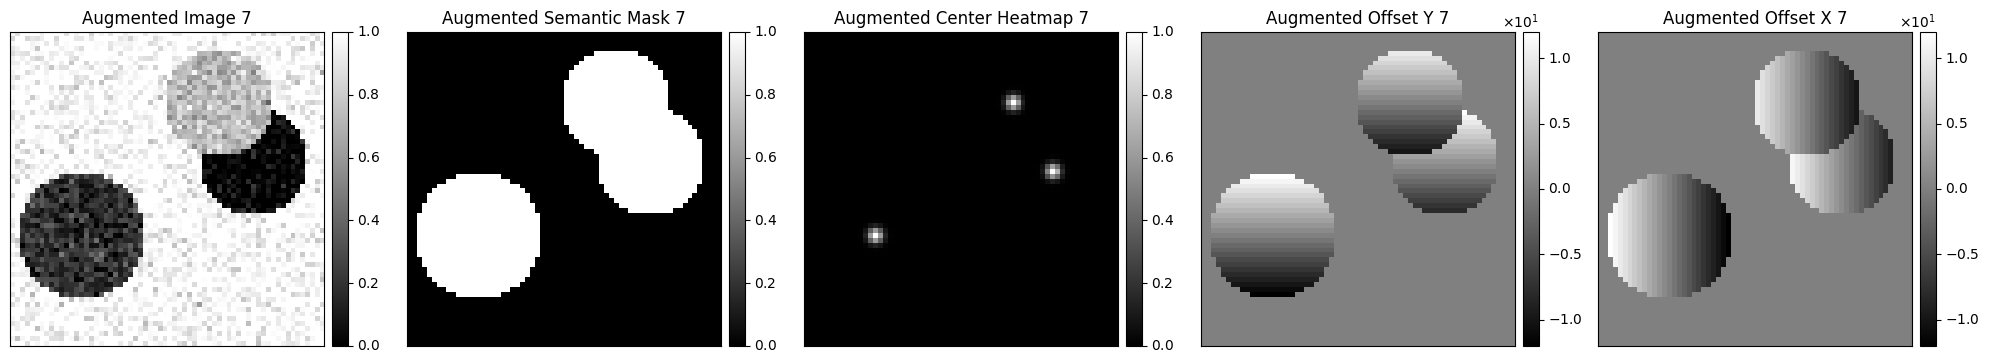

In [18]:
augment_factor = 1  ## not augmenting by flipping/rotating, just adding noise
## If using each image multiple times, need to make sure that the same image doesn't appear in
## both the training and validation sets

augmented_images, augmented_labels = augment_dataset(
    images,
    labels,
    augment_factor=augment_factor,
    noise_level=0.1,
    rng=rng,
    flip=False,  # for flipping and rotating it would need to also modify the offsets, currently does not
    rotate=False,
)

print(
    f"Final augmented dataset shape: {augmented_images.shape}, labels shape: {augmented_labels.shape}"
)

i = 7
show_2d(
    [
        augmented_images[i].squeeze(),
        augmented_labels[i][0],
        augmented_labels[i][1],
        augmented_labels[i][2],
        augmented_labels[i][3],
    ],
    cbar=True,
    norm="minmax",
    title=[
        f"Augmented Image {i}",
        f"Augmented Semantic Mask {i}",
        f"Augmented Center Heatmap {i}",
        f"Augmented Offset Y {i}",
        f"Augmented Offset X {i}",
    ],
);

In [19]:
dataset = SimpleDataset(augmented_images, augmented_labels)

# Split into train and validation sets
val_factor = 0.2
train_size = int((1 - val_factor) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=rng_torch)

print(f"Length of train dataset: {len(train_dataset)} | validation dataset: {len(val_dataset)}")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Train loader batches: {len(train_loader)} | Validation loader batches: {len(val_loader)}")

Length of train dataset: 16000 | validation dataset: 4000
Train loader batches: 500 | Validation loader batches: 125


We need to modify our CNN slightly to allow for different activation functions for each output channel, so we make a MultiChannelCNN2d to do so
- note that because we're outputting so much more info, training the nn is slower and it requires a lot more data. I suspect that if you removed the centers channel (e.g. because you were sure you didn't want to do watershed) then it would train a little faster, but really i suspect the slow/difficult channels are the offsets.

In [20]:
from quantem.core.ml.activation_functions import get_activation_function


class MultiChannelCNN2d(CNN2d):
    def __init__(
        self,
        in_channels=1,
        out_channels: int = 4,
        final_activations: list = ["sigmoid", "sigmoid", "identity", "identity"],
        **kwargs
    ):
        # Always use identity activation in base CNN, handle activations here
        super().__init__(in_channels=in_channels, out_channels=out_channels, final_activation="identity", **kwargs)
        self.final_activations = final_activations

    @property
    def final_activations(self): 
        return self._final_activations
    
    @final_activations.setter
    def final_activations(self, value):
        if not isinstance(value, (list, tuple)) or len(value) != self.out_channels:
            raise ValueError(f"final_activations must be a list of length {self.out_channels}")
        self._final_activations = [get_activation_function(act, self.dtype) for act in value]

    def forward(self, x):
        out = super().forward(x) # B,C,H,W
        # Apply per-channel activation
        outs = []
        for i, fn in enumerate(self.final_activations):
            outs.append(fn(out[:, i:i+1]))
        return torch.cat(outs, dim=1)

In [21]:
instance_model = MultiChannelCNN2d(
    in_channels=1,
    start_filters=32, 
    out_channels=4, # 4 channels for semantic, center heatmap, offset y, offset x
    final_activations=["sigmoid", "sigmoid", "identity", "identity"],
)
instance_model = instance_model.to(gpu_id)

optimizer = torch.optim.Adam(
    instance_model.parameters(), lr=1e-5 * np.sqrt(batch_size)
)  # Adjust learning rate based on batch size

def loss_function(outputs, targets):
    """
    Custom loss function for multi-channel output.
    """
    semantic_loss = torch.nn.functional.binary_cross_entropy(outputs[:, 0], targets[:, 0])
    center_loss = torch.nn.functional.binary_cross_entropy(outputs[:, 1], targets[:, 1])
    offset_loss = torch.nn.functional.mse_loss(outputs[:, 2:], targets[:, 2:])
    return semantic_loss + 5 * center_loss + offset_loss

train_losses = []
val_losses = []

  0%|          | 0/20 [00:00<?, ?it/s]

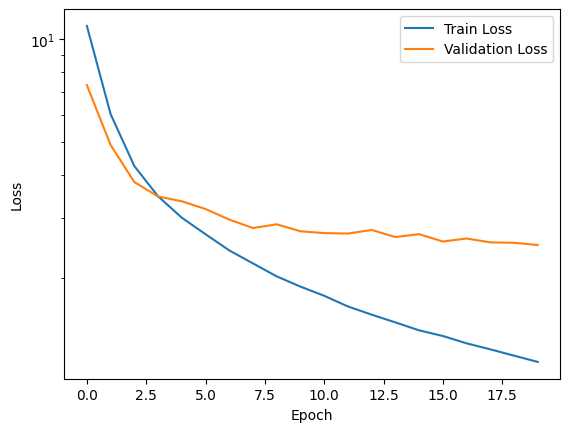

In [22]:
num_epochs = 20 # takes about 3 min 

for epoch in tqdm(range(num_epochs)):
    instance_model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(gpu_id), targets.to(gpu_id)

        optimizer.zero_grad()
        outputs = instance_model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    instance_model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(gpu_id), targets.to(gpu_id)

            outputs = instance_model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

fig, ax = plt.subplots()
ax.semilogy(train_losses, label="Train Loss")
ax.semilogy(val_losses, label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()


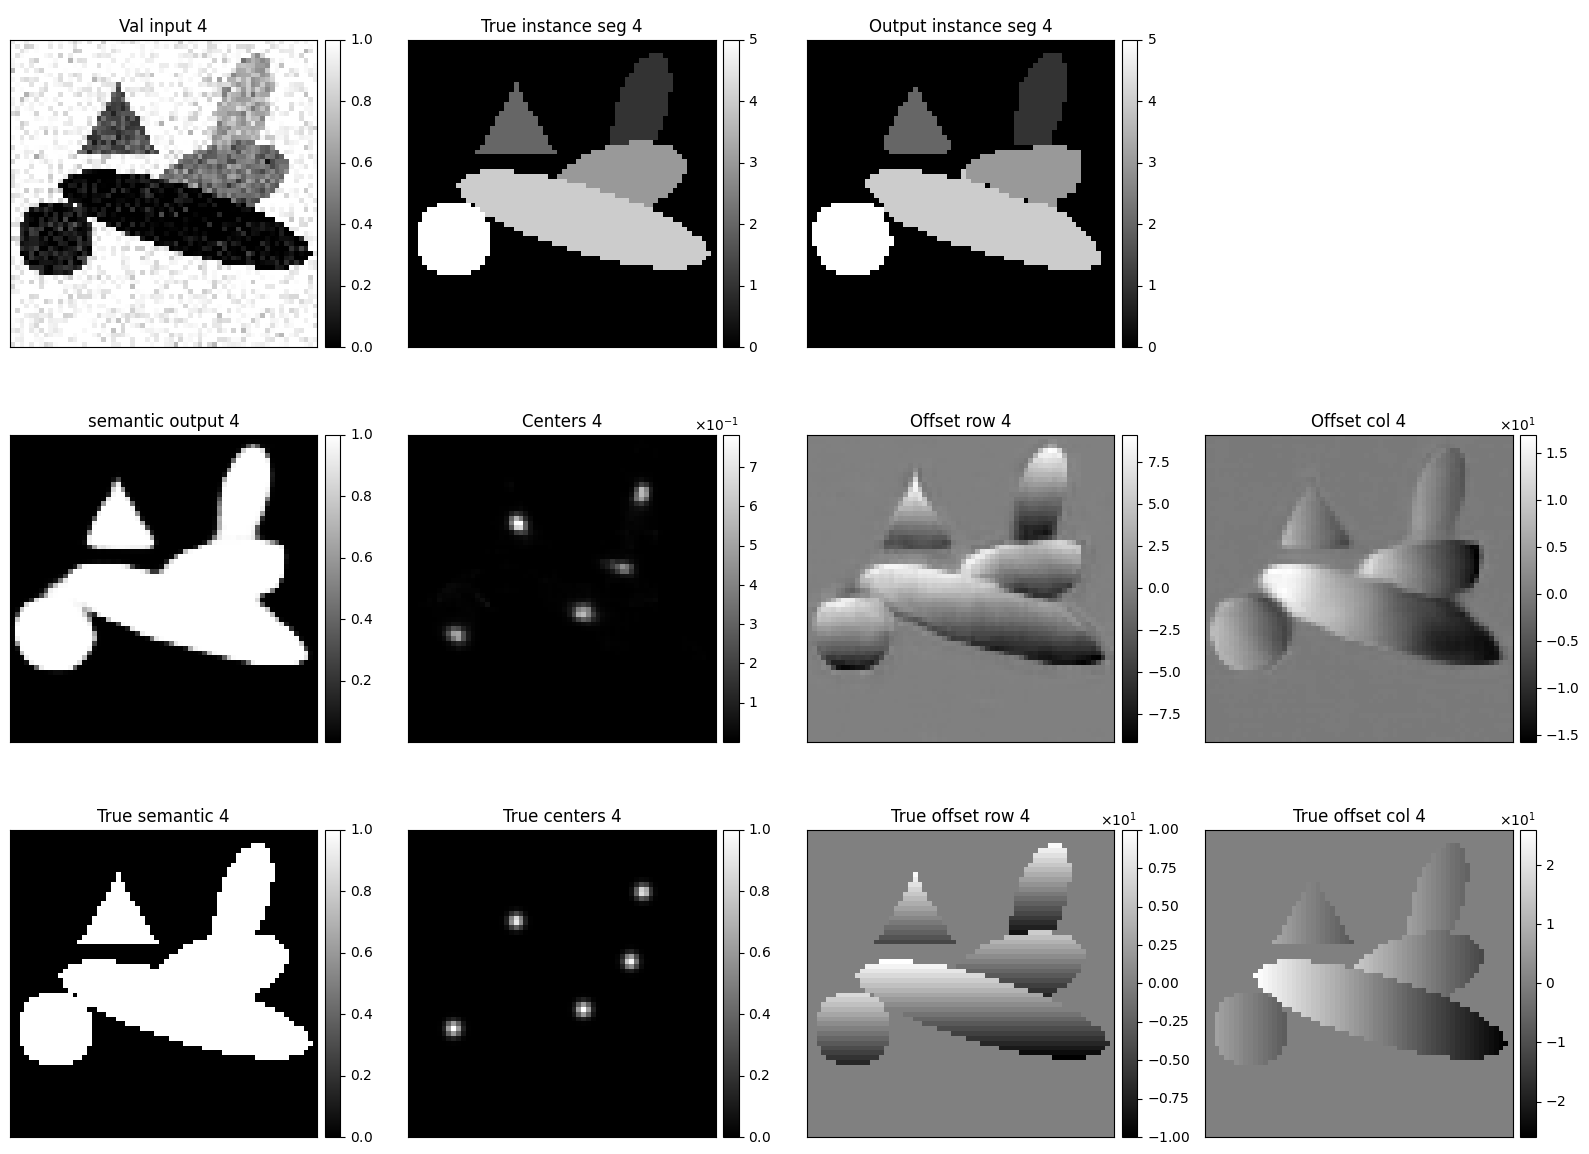

In [23]:
i = 4
thresh_val = 0.5

inp, lab = val_dataset[i]
true_res = dbscan_clustering(lab)
out = instance_model(inp[None, ...].to(gpu_id)).squeeze().cpu().detach().numpy()
res = dbscan_clustering(out, semantic_threshold=thresh_val, eps=2,)
# res = meanshift_clustering(out)
# res = watershed_clustering(out, center_threshold=0.1,)

show_2d(
    [
        [inp.squeeze(),
        true_res,
        res],
        [out[0],
        out[1],
        out[2],
        out[3]],
        [
            lab[0],
            lab[1],
            lab[2],
            lab[3],
        ]
    ],
    cbar=True,
    norm="minmax",
    title=[[f"Val input {i}", f"True instance seg {i}", f"Output instance seg {i}"], [f"semantic output {i}", f"Centers {i}", f"Offset row {i}", f"Offset col {i}"],
        [f"True semantic {i}", f"True centers {i}", f"True offset row {i}", f"True offset col {i}"]],
);


# Deep image prior
Using a CNN as a generative network 

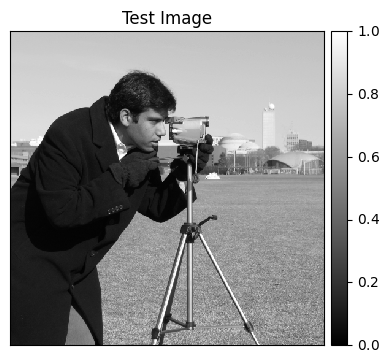

In [24]:
test_im = np.load("../data/cameraman.npy")
show_2d(test_im, title="Test Image", cbar=True, norm="minmax");

  0%|          | 0/250 [00:00<?, ?it/s]

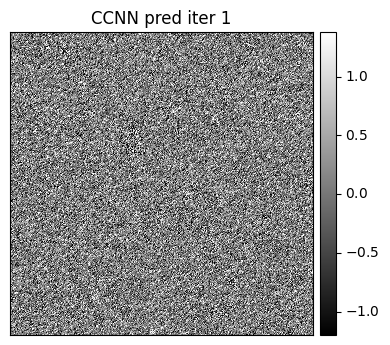

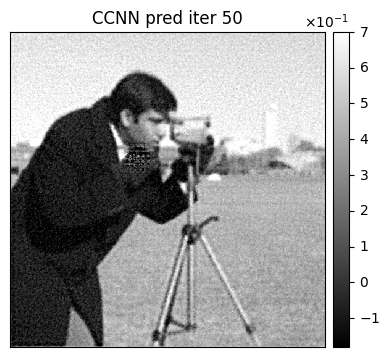

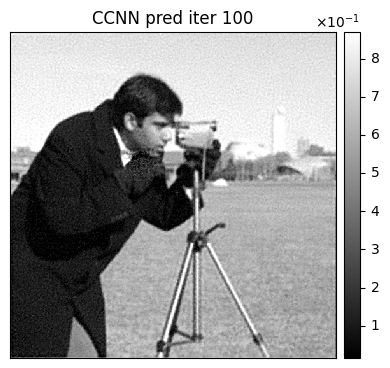

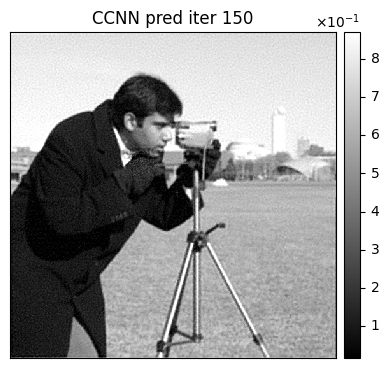

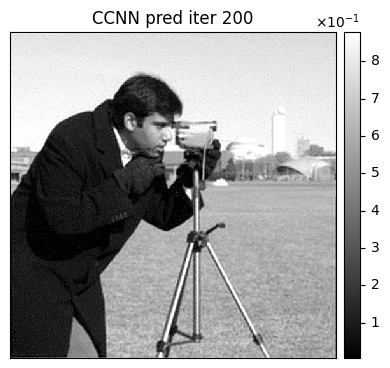

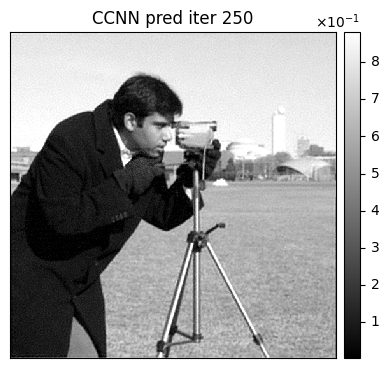

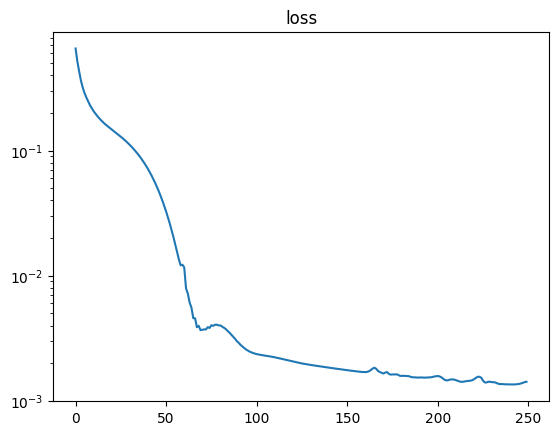

In [25]:
input_channels = 1
shape = (input_channels, *test_im.shape)
start_filters = 16
num_layers = 4
num_per_layer = 2
use_skip_connections = True
dtype = torch.float32
dropout = 0

dip = CNN2d(
    in_channels=input_channels,
    start_filters=start_filters,
    num_layers=num_layers,
    num_per_layer=num_per_layer,
    use_skip_connections=use_skip_connections,
    dtype=dtype,
    dropout=dropout,
    use_batchnorm=True,
)
dip.to(gpu_id)

optimizer = torch.optim.Adam([{"params": dip.parameters(), "lr": 1e-3}])

losses = []
input = torch.rand(*test_im.shape, dtype=dtype, device=gpu_id)[None, None, ...]
target = torch.tensor(test_im, dtype=dtype, device=gpu_id)[None, None, ...]

show_every = 50

target = target.to(gpu_id)
for a0 in tqdm(range(250)):
    pred = dip.forward(input).squeeze()
    loss = torch.mean((pred - target) ** 2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())

    if a0 == 0 or ((a0 + 1) % show_every == 0):
        show_2d(
            pred.cpu().detach().numpy(),
            title=f"CCNN pred iter {a0 + 1}",
            cbar=True,
            force_show=True,
        )
        plt.show()

fig, ax = plt.subplots()
ax.semilogy(losses)
ax.set_title("loss")
plt.show()

dip.eval()
pred = dip.forward(input).squeeze()
plt.close("all")